In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import seaborn as sns

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

In [2]:
dataDir='data_folder_smallCyl/'
dataFiles=np.sort([filename for filename in os.listdir(dataDir) if ".dat" in filename])
dataFiles

array(['window_00_rest.step_10.dat', 'window_00_rest.step_8.dat',
       'window_00_rest.step_9.dat', 'window_01_rest.step_10.dat',
       'window_01_rest.step_8.dat', 'window_01_rest.step_9.dat',
       'window_02_rest.step_10.dat', 'window_02_rest.step_8.dat',
       'window_02_rest.step_9.dat', 'window_03_rest.step_10.dat',
       'window_03_rest.step_8.dat', 'window_03_rest.step_9.dat',
       'window_04_rest.step_10.dat', 'window_04_rest.step_8.dat',
       'window_04_rest.step_9.dat', 'window_05_rest.step_10.dat',
       'window_05_rest.step_8.dat', 'window_05_rest.step_9.dat',
       'window_06_rest.step_10.dat', 'window_06_rest.step_8.dat',
       'window_06_rest.step_9.dat', 'window_07_rest.step_10.dat',
       'window_07_rest.step_8.dat', 'window_07_rest.step_9.dat',
       'window_08_rest.step_10.dat', 'window_08_rest.step_8.dat',
       'window_08_rest.step_9.dat', 'window_09_rest.step_10.dat',
       'window_09_rest.step_8.dat', 'window_09_rest.step_9.dat',
       'window_

In [3]:
datColNames=['Frame','Rst00_Z','XY_Radius']
crdColumns=['Frame','Rst00_Z','XY_Radius']
windowDataTables=[]
windowTable=[]
tempTable=[]
for datFile in dataFiles:
    #print ('loading milestone coordinate data from %s'%datFile)
    datFilePath=dataDir+'/'+datFile
    window=np.int(datFile.split('_')[1])
    
    if 'rep_' in datFile:
        rep=np.int(datFile.split('.')[1].split('_')[1])
        #print (rep)
    else:
        rep=1

    tempTable=pd.read_csv(datFilePath,delim_whitespace=True,names=datColNames)
    tempTable['Window']=window
    tempTable['Rep']=rep
    windowTable=tempTable[['Window','Rep']].copy()
    #windowTable=tempTable[['Window']].copy()
    windowTable['Time']=tempTable['Frame']
    for crdColumn in crdColumns:
        windowTable[crdColumn]=tempTable[crdColumn]
    windowDataTables.append(windowTable.copy())
#simData=pd.concat(windowDataTables).query("(Time<11)")
simData=pd.concat(windowDataTables)
print(simData)


       Window  Rep      Time     Frame    Rst00_Z  XY_Radius
0           0    1         0         0 -27.608865   2.207269
1           0    1       200       200 -27.054186   1.977292
2           0    1       400       400 -26.806384   2.891736
3           0    1       600       600 -26.839846   3.106608
4           0    1       800       800 -26.396591   3.322032
...       ...  ...       ...       ...        ...        ...
99995      27    1  19999000  19999000  27.755441   5.009898
99996      27    1  19999200  19999200  27.942983   4.893167
99997      27    1  19999400  19999400  28.026607   4.651274
99998      27    1  19999600  19999600  27.516518   4.738751
99999      27    1  19999800  19999800  27.480306   4.907999

[13722683 rows x 6 columns]


In [4]:
windowRestraintTable=pd.read_csv('win_center_cyl.txt',delim_whitespace=True,header=None)
windowRestraintTable.columns=['lowerWall','upperWall']
windowRestraintTable['Window']=np.arange(0,28)
#windowRestraintTable['FC1']=100
#windowRestraintTable['FC2']=100
print (windowRestraintTable)

    lowerWall  upperWall  Window
0       -28.0      -26.0       0
1       -26.0      -24.0       1
2       -24.0      -22.0       2
3       -22.0      -20.0       3
4       -20.0      -18.0       4
5       -18.0      -16.0       5
6       -16.0      -14.0       6
7       -14.0      -12.0       7
8       -12.0      -10.0       8
9       -10.0       -8.0       9
10       -8.0       -6.0      10
11       -6.0       -4.0      11
12       -4.0       -2.0      12
13       -2.0        0.0      13
14        0.0        2.0      14
15        2.0        4.0      15
16        4.0        6.0      16
17        6.0        8.0      17
18        8.0       10.0      18
19       10.0       12.0      19
20       12.0       14.0      20
21       14.0       16.0      21
22       16.0       18.0      22
23       18.0       20.0      23
24       20.0       22.0      24
25       22.0       24.0      25
26       24.0       26.0      26
27       26.0       28.0      27


In [5]:
print(windowRestraintTable['upperWall'][27])
print(windowRestraintTable['lowerWall'][0])

28.0
-28.0


In [6]:
simData.head()

,Window,Rep,Time,Frame,Rst00_Z,XY_Radius
0,0,1,0,0,-27.608865,2.207269
1,0,1,200,200,-27.054186,1.977292
2,0,1,400,400,-26.806384,2.891736
3,0,1,600,600,-26.839846,3.106608
4,0,1,800,800,-26.396591,3.322032


In [7]:
milestone_data_table=pd.merge(simData,windowRestraintTable)
milestone_data_table.to_csv('merged.csv',index=False)
print(milestone_data_table)
df=[]
df=milestone_data_table

          Window  Rep      Time     Frame    Rst00_Z  XY_Radius  lowerWall  \
0              0    1         0         0 -27.608865   2.207269      -28.0   
1              0    1       200       200 -27.054186   1.977292      -28.0   
2              0    1       400       400 -26.806384   2.891736      -28.0   
3              0    1       600       600 -26.839846   3.106608      -28.0   
4              0    1       800       800 -26.396591   3.322032      -28.0   
...          ...  ...       ...       ...        ...        ...        ...   
13722678      27    1  19999000  19999000  27.755441   5.009898       26.0   
13722679      27    1  19999200  19999200  27.942983   4.893167       26.0   
13722680      27    1  19999400  19999400  28.026607   4.651274       26.0   
13722681      27    1  19999600  19999600  27.516518   4.738751       26.0   
13722682      27    1  19999800  19999800  27.480306   4.907999       26.0   

          upperWall  
0             -26.0  
1             -26.0

In [8]:
conditions=[ 
    (df['Rst00_Z']>df['lowerWall']) & (df['Rst00_Z']<=df['upperWall']), # lowerwall<z<upperwall, X_index=window
    (df['Rst00_Z']<=df['lowerWall']), # z<=lowerwall, X_index=window-1
    (df['Rst00_Z']>df['upperWall']), # z>upperwall, X_index=window+1
]
choices = [df['Window'], df['Window']-1, df['Window']+1]

df['X_Index']=np.select(conditions, choices)
print(df)
#df.to_csv("/data/lyna/CNT/df.csv")
print(df.X_Index.unique()) 

          Window  Rep      Time     Frame    Rst00_Z  XY_Radius  lowerWall  \
0              0    1         0         0 -27.608865   2.207269      -28.0   
1              0    1       200       200 -27.054186   1.977292      -28.0   
2              0    1       400       400 -26.806384   2.891736      -28.0   
3              0    1       600       600 -26.839846   3.106608      -28.0   
4              0    1       800       800 -26.396591   3.322032      -28.0   
...          ...  ...       ...       ...        ...        ...        ...   
13722678      27    1  19999000  19999000  27.755441   5.009898       26.0   
13722679      27    1  19999200  19999200  27.942983   4.893167       26.0   
13722680      27    1  19999400  19999400  28.026607   4.651274       26.0   
13722681      27    1  19999600  19999600  27.516518   4.738751       26.0   
13722682      27    1  19999800  19999800  27.480306   4.907999       26.0   

          upperWall  X_Index  
0             -26.0        0  
1

In [9]:
#df.query('X_Index ==0')
#df

C:\Users\19094\Anaconda2\envs\p36workshop\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Window', ylabel='X_Index'>

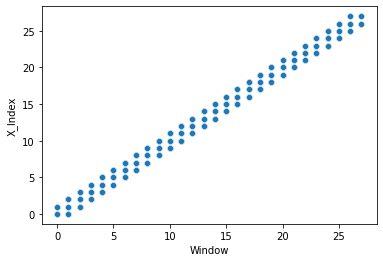

In [10]:
df.replace({'X_Index':-1}, 0, inplace=True)
df.replace({'X_Index':28}, 27, inplace=True)
sns.scatterplot(df.Window, df.X_Index)

In [11]:
simData=df
display(simData.head())
simData.tail()

,Window,Rep,Time,Frame,Rst00_Z,XY_Radius,lowerWall,upperWall,X_Index
0,0,1,0,0,-27.608865,2.207269,-28.0,-26.0,0
1,0,1,200,200,-27.054186,1.977292,-28.0,-26.0,0
2,0,1,400,400,-26.806384,2.891736,-28.0,-26.0,0
3,0,1,600,600,-26.839846,3.106608,-28.0,-26.0,0
4,0,1,800,800,-26.396591,3.322032,-28.0,-26.0,0


,Window,Rep,Time,Frame,Rst00_Z,XY_Radius,lowerWall,upperWall,X_Index
13722678,27,1,19999000,19999000,27.755441,5.009898,26.0,28.0,27
13722679,27,1,19999200,19999200,27.942983,4.893167,26.0,28.0,27
13722680,27,1,19999400,19999400,28.026607,4.651274,26.0,28.0,27
13722681,27,1,19999600,19999600,27.516518,4.738751,26.0,28.0,27
13722682,27,1,19999800,19999800,27.480306,4.907999,26.0,28.0,27


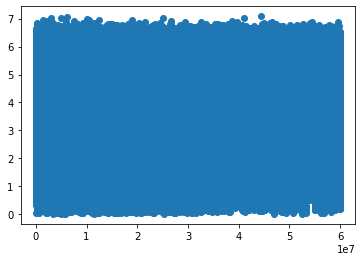

In [14]:
plt.figure(figsize=(15,4))
plotName=[]
plotData=[]
transitData=[]
centerData=[]

for group in simData.groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window ==X_Index')
    
    plt.scatter(x=centerData.Rst00_Z, y=centerData.XY_Radius,s=1,alpha=0.25)
    plt.scatter(x=transitData.Rst00_Z, y=transitData.XY_Radius,s=1,alpha=0.25)
plt.xlabel("z")
plt.ylabel("xy radius")
plt.xticks(np.arange(-18,18,1))
plt.grid( linestyle='-', linewidth=1)
plt.show()


In [15]:
simData.to_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.2ps.10.4.csv',index=False)

In [3]:
tt=pd.read_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.5ps.csv')
print (tt.head())

   Window  Rep  Time  Frame    Rst00_Z  XY_Radius  lowerWall  upperWall  \
0       0    1     0      0 -26.435905   5.872915      -28.0      -26.0   
1       0    1   500    500 -26.117360   5.653717      -28.0      -26.0   
2       0    1  1000   1000 -26.374524   5.762395      -28.0      -26.0   
3       0    1  1500   1500 -25.987833   5.606116      -28.0      -26.0   
4       0    1  2000   2000 -26.061743   5.124574      -28.0      -26.0   

   X_Index  
0        0  
1        0  
2        0  
3        1  
4        0  


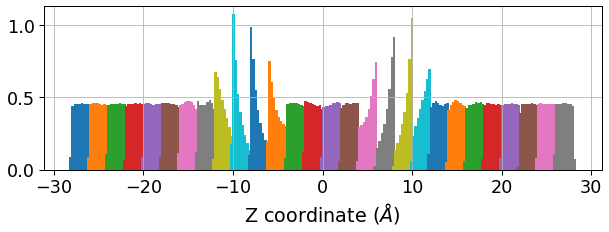

In [4]:
plt.figure(figsize=(10,3))
sns.set_context("paper",font_scale=2)
#plt.figure(figsize=(15,4))
plotName=[]
plotData=[]
transitData=[]
centerData=[]

for group in tt.groupby('Window'):
    plotName,plotData=group
    transitData=plotData
    x=np.arange(0,len(transitData.Time))
    plt.hist(transitData.Rst00_Z,histtype='stepfilled',density=True)
    plt.grid(True)
    plt.xlabel('Z coordinate ($\AA$)')
    #plt.ylabel('count')
    #a=transitData[0:200000]
    #a.to_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.5ps.100ns.csv',index=False)
    #print (a) 
plt.show()

In [11]:
tt=pd.read_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.5ps.csv')

In [153]:
#a.to_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.5ps.20ns.csv')

In [180]:
a=tt.groupby('Window').head(200000).reset_index(drop=True)

In [181]:
a.tail()

,Window,Rep,Time,Frame,Rst00_Z,XY_Radius,lowerWall,upperWall,X_Index
5599995,27,1,44997500,44997500,27.260246,2.476758,26.0,28.0,27
5599996,27,1,44998000,44998000,28.097532,2.903020,26.0,28.0,27
5599997,27,1,44998500,44998500,27.019007,2.880595,26.0,28.0,27
5599998,27,1,44999000,44999000,27.326118,3.293590,26.0,28.0,27
5599999,27,1,44999500,44999500,27.951333,3.336653,26.0,28.0,27


In [182]:
a.to_csv('Simulation_Milestone_Coordinate_Data.allCyl.0.5ps.100ns.csv',index=False)

In [7]:
traj_5ps=972367*5/1000
colars_5ps=995475*5/1000
colvars_2ps=2488698*2/1000
colvars_1ps=4977401*1/1000
colvars_05ps=9954806*0.5/1000
colvars_02ps=5320001*0.2/1000
#colvars_02ps=13722000*0.2/1000

In [8]:
print ("traj_5ps:",traj_5ps, "ns")
print ("5ps:", colars_5ps, "ns")
print ("2ps:", colvars_2ps, "ns")
print ("1ps:", colvars_1ps, "ns")
print ("0.5ps:", colvars_05ps, "ns")
print ("0.2ps:", colvars_02ps, "ns")

traj_5ps: 4861.835 ns
5ps: 4977.375 ns
2ps: 4977.396 ns
1ps: 4977.401 ns
0.5ps: 4977.403 ns
0.2ps: 1064.0002 ns


In [54]:
posV=pd.read_csv('pos0.8_ion_num.csv',delim_whitespace=True)
posV.columns=['Frame','ion_num_pos']
negV=pd.read_csv('neg0.8_ion_num.csv',delim_whitespace=True)
negV.columns=['Frame','ion_num']
# print ("positive lenght",len(posV))
# print ("negative lenght", len(negV))
print (posV.head())

   Frame  ion_num_pos
0      1            2
1      2            2
2      3            1
3      4            2
4      5            2


In [55]:
df['Frame']=posV['Frame']
df['ion_num_pos']=posV['ion_num_pos']
df['ion_num_neg']=negV['ion_num']
#print (posV.head())
#print (df.head())
df=df.append(df[['ion_num_pos','ion_num_neg']].sum(),ignore_index=True).fillna('')
print (df.tail())
#print (posV.head())

       Frame ion_num_pos ion_num_neg
49996  49997           1           1
49997  49998           1           2
49998  49999           1           2
49999                               
50000              91939       91677


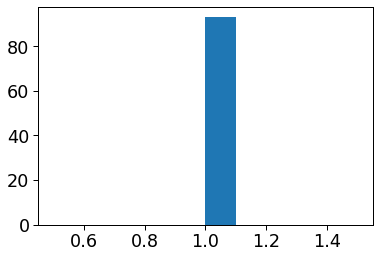

(array([  0.,   0.,   0.,   0.,   0., 172.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

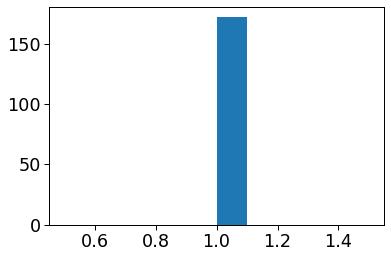

In [52]:
plt.hist(posV.query('ion_num_pos != 0').ion_num_pos)
plt.show()
plt.hist(negV.query('ion_num != 0').ion_num)
#plt.hist(negV.ion_num)

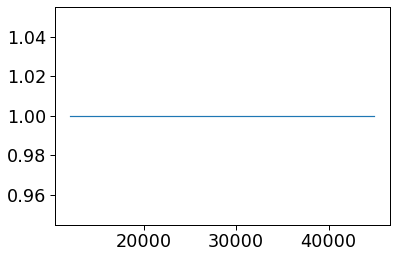

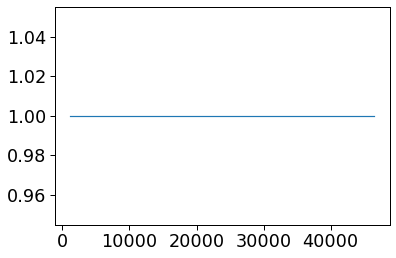

In [53]:
plt.plot(posV.query('ion_num_pos != 0').ion_num_pos)
plt.show()
plt.plot(negV.query('ion_num != 0').ion_num)
#plt.hist(negV.ion_num)